In [ ]:
# Financial Influence on Transfer Network
# Research Question: How do financial differences shape the transfer network?

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import community.community_louvain as community_louvain




# Load Dataset
file_path = "Transfer-Players-Clubs.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

In [ ]:
# Clean and Process Financial Metric
# Convert 'net_transfer_record' to numeric (remove symbols)
df['net_transfer_record_clean'] = df['net_transfer_record'].str.replace(r'[^\d.-]', '', regex=True).astype(float)



In [ ]:
# Categorize Clubs by Spending Tier
# Create a mapping of club to average net transfer record
club_finance = df.groupby('from_club_name')['net_transfer_record_clean'].mean().to_dict()

# Assign each club to a tier
quantiles = pd.qcut(list(club_finance.values()), q=3, labels=["Low", "Medium", "High"])
club_tiers = dict(zip(club_finance.keys(), quantiles))

In [ ]:
# Build Directed Network of Transfers
G = nx.DiGraph()
for _, row in df.iterrows():
    from_club = row['from_club_name']
    to_club = row['to_club_name']
    if from_club and to_club:
        G.add_edge(from_club, to_club)

In [ ]:
#Analyze Transfer Flows Between Tiers
transfer_matrix = defaultdict(int)
for u, v in G.edges():
    tier_u = club_tiers.get(u, "Unknown")
    tier_v = club_tiers.get(v, "Unknown")
    transfer_matrix[(tier_u, tier_v)] += 1

In [ ]:
#Convert to DataFrame for heatmap
tiers = ["Low", "Medium", "High"]
matrix_df = pd.DataFrame(0, index=tiers, columns=tiers)
for (src, tgt), count in transfer_matrix.items():
    if src in tiers and tgt in tiers:
        matrix_df.loc[src, tgt] = count

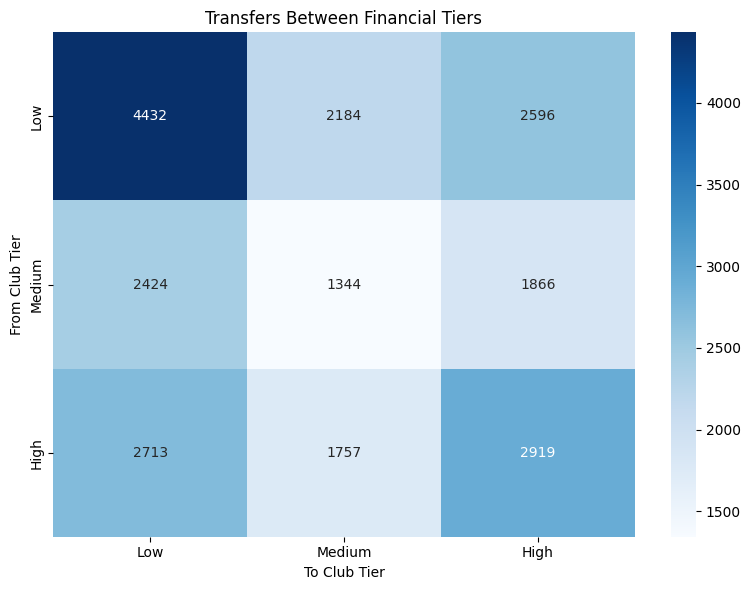

In [ ]:
#Visualize Transfer Tier Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_df, annot=True, cmap="Blues", fmt="d")
plt.title("Transfers Between Financial Tiers")
plt.xlabel("To Club Tier")
plt.ylabel("From Club Tier")
plt.tight_layout()
plt.show()

In [ ]:
#Summary Interpretation
print("\nSummary of Transfers Between Financial Tiers:")
print(matrix_df)



Summary of Transfers Between Financial Tiers:
         Low  Medium  High
Low     4432    2184  2596
Medium  2424    1344  1866
High    2713    1757  2919


In [ ]:

# For community detection, we convert to undirected graph
G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected)

# Count how many clubs fall into each community
from collections import Counter
community_sizes = Counter(partition.values())
print("\nCommunity sizes:")
print(dict(community_sizes))



Community sizes:
{0: 284, 6: 408, 2: 495, 3: 592, 4: 345, 7: 276, 12: 285, 9: 357, 11: 333, 10: 2, 1: 2, 5: 2, 8: 2}


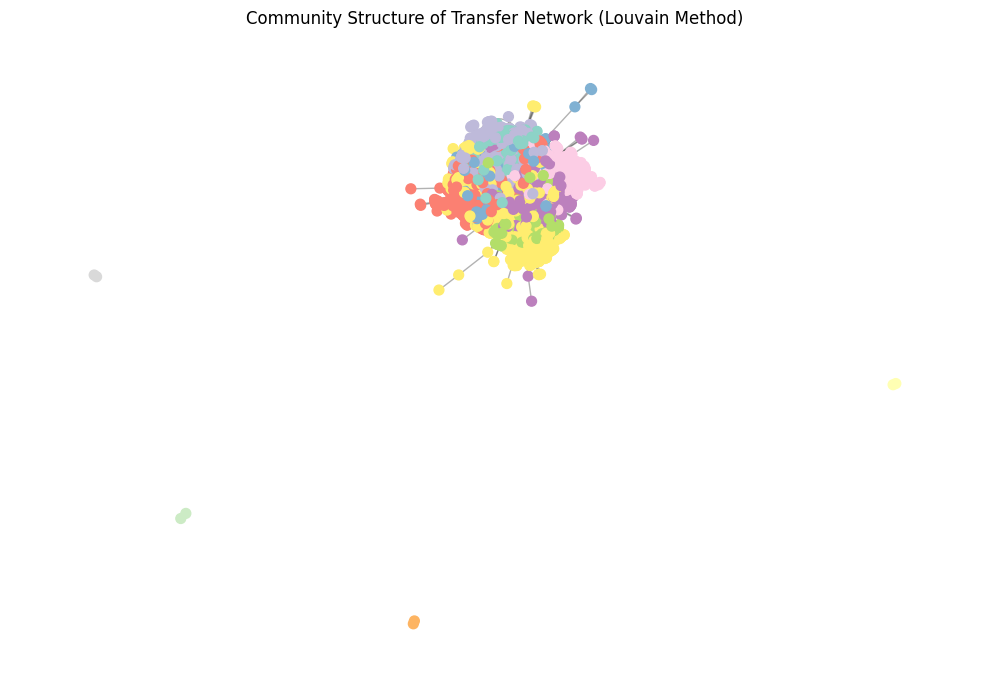

In [38]:
# Visualize the communities
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_undirected, seed=42)
nx.draw_networkx_nodes(G_undirected, pos, node_size=50,
                       cmap=plt.cm.Set3,
                       node_color=list(partition.values()))
nx.draw_networkx_edges(G_undirected, pos, alpha=0.3)
plt.title("Community Structure of Transfer Network (Louvain Method)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Export Graph to GEXF for Gephi
for node in G_undirected.nodes():
    G_undirected.nodes[node]['community'] = partition.get(node)
nx.write_gexf(G_undirected, "transfer_network_communities.gexf")
print("\nGEXF file exported: transfer_network_communities.gexf")


GEXF file exported: transfer_network_communities.gexf
